# MNIST CNN model

**FINAL Targets to keep in mind**:

- 99.4% accuracy on test dataset ( should be consistent in last few epochs)
- less than equal to 15 epochs
- less than 10k parameters

## Connecting drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!ls

In [0]:
import os
os.chdir("./drive/My Drive/EVA/Session05")

## Importing Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from torchvision import datasets, transforms

from torchsummary import summary
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)

## GPU for training

In [4]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

try:
  print(f"Found GPU at : {device_name}")
except:
  print("GPU device not found.")

Found GPU at : /device:GPU:0


In [5]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  use_cuda = True
  print(f"Number of GPU's available : {torch.cuda.device_count()}")
  print(f"GPU device name : {torch.cuda.get_device_name(0)}")
else:
  print("No GPU available, using CPU instead")
  device = torch.device("cpu")
  use_cuda = False

Number of GPU's available : 1
GPU device name : Tesla K80


In [6]:
SEED = 1
torch.manual_seed(SEED)

## Data Transformation

In [0]:
#training data transformation

train_transforms = transforms.Compose([
                                       #transforms.RandomRotation((-5,5), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,))
])

test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,))
])

## Downloading MNIST dataset with applied transformation

Things to keep in mind, 
- the dataset is provided by pytorch community.
- MNIST dataset contains: 
  - 60,000 training images
  - 10,000 test images 
  - Each image is of size (28x28x1).
- The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation for MNIST dataset.

In [0]:
#define some config parameters
batch_size = 128
num_epochs = 15
kernel_size = 3
pool_size = 2

lr = 0.001
momentum = 0.9

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

In [0]:
mnist_trainset = datasets.MNIST(root="./data", train=True, download=True,
                                transform=train_transforms)

mnist_testset = datasets.MNIST(root="./data", train=False, download=True,
                               transform=test_transforms)

## Train and Test Dataloader 

In [0]:
train_loader = torch.utils.data.DataLoader(mnist_trainset,
                                          batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(mnist_testset,
                                          batch_size=batch_size, shuffle=True, **kwargs)

## Visualization of images

In [0]:
examples = iter(train_loader)
example_data, example_targets = examples.next()

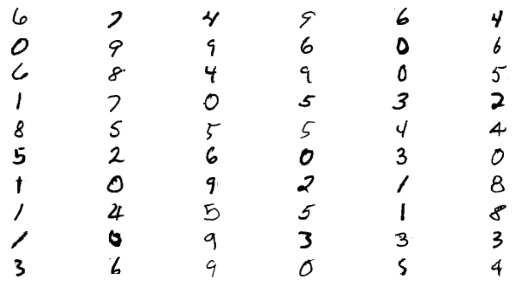

In [16]:
fig = plt.figure()
for i in range(60):
  plt.subplot(10,6,i+1)
  plt.axis('off')
  plt.imshow(example_data[i][0].numpy().squeeze(), cmap='gray_r')

## Defining training and testing functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    running_loss = 0.0
    running_correct = 0

    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        _, preds = torch.max(output.data, 1)
        loss.backward()
        optimizer.step()

        #calculate training running loss
        running_loss += loss.item()
        running_correct += (preds == target).sum().item()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    train_losses.append(running_loss/len(mnist_trainset))
    train_acc.append(100. * running_correct/len(mnist_trainset))
    print("\n")
    print(f"EPOCH {epoch} \n  TRAIN avg loss: {running_loss/len(mnist_trainset):.4f} train acc: {100. * running_correct/len(mnist_trainset):.4f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100.*correct/len(mnist_testset))

    print("\n")
    print(f"  TEST avg loss: {test_loss:.4f} test acc: {100. * correct/len(mnist_testset):.4f}\n")

## Building the model

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1block = nn.Sequential(
            nn.Conv2d(1, 16, 3),                            #(-1,28,28,1)>(-1,3,3,1,16)>(-1,26,26,16)>3
            nn.ReLU(),
            nn.Conv2d(16, 16, 3),                           #(-1,26,26,16)>(-1,3,3,16,16)>(-1,24,24,16)>5
            nn.ReLU(),
            nn.Conv2d(16, 16, 3),                           #(-1,24,24,16)>(-1,3,3,16,16)>(-1,22,22,16)>7
            nn.ReLU(),
        )

        self.pool1block = nn.Sequential(
            nn.MaxPool2d(2,2),                              #(-1,22,22,16)>(-1,11,11,16)>8
        )

        self.conv2block = nn.Sequential(
            nn.Conv2d(16, 16, 3),                           #(-1,11,11,16)>(-1,3,3,16,16)>(-1,9,9,16)>12
            nn.ReLU(),
            nn.Conv2d(16, 16, 3),                           #(-1,9,9,16)>(-1,3,3,16,16)>(-1,7,7,16)>16
            nn.ReLU(),
            nn.Conv2d(16, 16, 3),                           #(-1,7,7,16)>(-1,3,3,16,16)>(-1,5,5,16)>20
            nn.ReLU(),
        )

        self.avgpool = nn.AvgPool2d(5)                      #(-1,5,5,16)>(-1,1,1,16)>28
        self.conv3 = nn.Conv2d(16, 10, 1)                   #(-1,1,1,16)>(-1,1,1,16,10)>(-1,1,1,10)>28  

        
    def forward(self, x):
        x = self.conv1block(x)
        x = self.pool1block(x)
        x = self.conv2block(x)
        x = self.avgpool(x)
        x = self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [28]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           2,320
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           2,320
              ReLU-6           [-1, 16, 22, 22]               0
         MaxPool2d-7           [-1, 16, 11, 11]               0
            Conv2d-8             [-1, 16, 9, 9]           2,320
              ReLU-9             [-1, 16, 9, 9]               0
           Conv2d-10             [-1, 16, 7, 7]           2,320
             ReLU-11             [-1, 16, 7, 7]               0
           Conv2d-12             [-1, 16, 5, 5]           2,320
             ReLU-13             [-1, 16, 5, 5]               0
        AvgPool2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
#scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

for epoch in range(1, num_epochs+1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

loss=0.2789900004863739 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.87it/s]



EPOCH 1 
  TRAIN avg loss: 0.0044 train acc: 80.5883



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.1413 test acc: 95.2900



loss=0.00887976586818695 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]



EPOCH 2 
  TRAIN avg loss: 0.0010 train acc: 96.1917



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0864 test acc: 97.2500



loss=0.09168540686368942 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]




EPOCH 3 
  TRAIN avg loss: 0.0008 train acc: 96.9133


  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.1001 test acc: 96.9600



loss=0.12796002626419067 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.95it/s]




EPOCH 4 
  TRAIN avg loss: 0.0007 train acc: 97.2700


  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0881 test acc: 97.3400



loss=0.11634966731071472 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]



EPOCH 5 
  TRAIN avg loss: 0.0007 train acc: 97.3667



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0630 test acc: 98.0200



loss=0.030286068096756935 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]



EPOCH 6 
  TRAIN avg loss: 0.0006 train acc: 97.6583



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0735 test acc: 97.7400



loss=0.041026804596185684 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.86it/s]



EPOCH 7 
  TRAIN avg loss: 0.0006 train acc: 97.6750



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0709 test acc: 97.9100



loss=0.22251661121845245 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.49it/s]



EPOCH 8 
  TRAIN avg loss: 0.0006 train acc: 97.8283



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0915 test acc: 97.3400



loss=0.07321173697710037 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]



EPOCH 9 
  TRAIN avg loss: 0.0006 train acc: 97.7583



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0817 test acc: 97.4800



loss=0.07132694125175476 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]



EPOCH 10 
  TRAIN avg loss: 0.0005 train acc: 98.1017



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0596 test acc: 98.1900



loss=0.05319445952773094 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.27it/s]




EPOCH 11 
  TRAIN avg loss: 0.0005 train acc: 98.1333


  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0590 test acc: 98.3700



loss=0.03740996494889259 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]



EPOCH 12 
  TRAIN avg loss: 0.0005 train acc: 98.0800



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0595 test acc: 98.2100



loss=0.10443731397390366 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.62it/s]



EPOCH 13 
  TRAIN avg loss: 0.0004 train acc: 98.3150



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0638 test acc: 98.1900



loss=0.009459863416850567 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]



EPOCH 14 
  TRAIN avg loss: 0.0005 train acc: 98.1850



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0879 test acc: 97.6000



loss=0.0036650497931987047 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]



EPOCH 15 
  TRAIN avg loss: 0.0005 train acc: 98.1300




  TEST avg loss: 0.0653 test acc: 98.3000



In [0]:
epoch_count = range(1, len(train_losses) + 1)

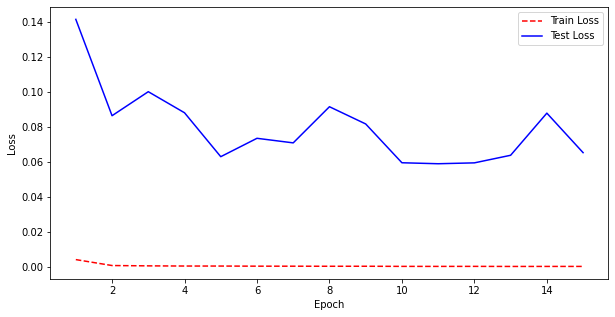

In [31]:
plt.plot(epoch_count, train_losses, 'r--')
plt.plot(epoch_count, test_losses, 'b-')
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

- there is huge gap between losses
- the test losses seems like we are using high learning rate


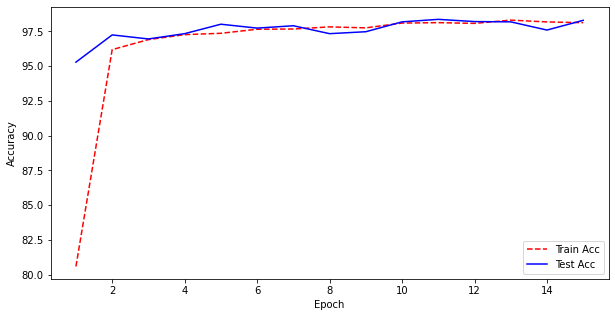

In [32]:
plt.plot(epoch_count, train_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Train Acc', 'Test Acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

- training accuracy is low, scope of learning